https://keras.io/examples/nlp/neural_machine_translation_with_transformer/

# English-to-Spanish translation with a sequence-to-sequence Transformer

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2021/05/26<br>
**Last modified:** 2023/02/25<br>
**Description:** Implementing a sequence-to-sequene Transformer and training it on a machine translation task.

## Introduction

In this example, we'll build a sequence-to-sequence Transformer model, which
we'll train on an English-to-Spanish machine translation task.

You'll learn how to:

- Vectorize text using the Keras `TextVectorization` layer.
- Implement a `TransformerEncoder` layer, a `TransformerDecoder` layer,
and a `PositionalEmbedding` layer.
- Prepare data for training a sequence-to-sequence model.
- Use the trained model to generate translations of never-seen-before
input sentences (sequence-to-sequence inference).

The code featured here is adapted from the book
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapter 11: Deep learning for text).
The present example is fairly barebones, so for detailed explanations of
how each building block works, as well as the theory behind Transformers,
I recommend reading the book.

## Setup

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
random.seed(57)

## Downloading the data

We'll be working with an English-to-Spanish translation dataset
provided by [Anki](https://www.manythings.org/anki/). Let's download it:

## Parsing the data

Each line contains an English sentence and its corresponding Spanish sentence.
The English sentence is the *source sequence* and Spanish one is the *target sequence*.
We prepend the token `"[start]"` and we append the token `"[end]"` to the Spanish sentence.

# BaNeL dataset loading

In [2]:
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/Jak57/datasets/main/banel/banel_pos_90_10/banel_pos_train_20118_90_10.csv"
df = pd.read_csv(url)
print("Shape:", df.shape, "\n")
df.head(20)

Shape: (20118, 4) 



,Unnamed: 0,Inflected_Word,Lemma,POS
0,0,কাচিতেছিলাম,কাচা,ক্রিয়া
1,1,আগমনকারী,আগমন,বিশেষ্য
2,2,ফলা,ফল,বিশেষ্য
3,3,এলাকার,এলাকা,বিশেষ্য
4,4,ডাকাতীর,ডাকাতী,বিশেষণ
5,5,লম্বন,লম্ব,বিশেষ্য
6,6,ঐতিহাসিকভাবে,ঐতিহাসিক,বিশেষণ
7,7,ওখানখার,ওখান,বিশেষ্য
8,8,জনে,জন,বিশেষ্য
9,9,ছোলা,ছোলা,বিশেষ্য


In [3]:
def word_sentence(word):
  sentence = ""
  for ch in word:
    sentence += (ch + " ")
  return sentence

In [4]:
text_pairs = []
for index, row in df.iterrows():
  pos = row["POS"]
  inflected_word = word_sentence(row["Inflected_Word"]) + pos
  lemma = row["Lemma"]
  lemma = "[start] " + word_sentence(lemma) + "[end]"
  text_pairs.append((inflected_word, lemma))

In [5]:
print(len(text_pairs))

20118


Here's what our sentence pairs look like:

In [6]:
for _ in range(5):
    print(random.choice(text_pairs))

('ঠ ে ল া ক্রিয়া', '[start] ঠ ে ল া [end]')
('অ চ ল া ব স ্ থ া য় বিশেষ্য', '[start] অ চ ল া [end]')
('চ র ্ ব ি জ ন ি ত বিশেষ্য', '[start] চ র ্ ব ি [end]')
('ব া ঁ চ া র বিশেষ্য', '[start] ব া ঁ চ া [end]')
('প ণ ্ য ে র বিশেষ্য', '[start] প ণ ্ য [end]')


Now, let's split the sentence pairs into a training set, a validation set,
and a test set.

In [7]:
random.shuffle(text_pairs)
num_val_samples = int(0.1 * len(text_pairs))
num_train_samples = len(text_pairs) -  num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples :]
test_pairs = text_pairs[num_train_samples :]


print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

print(train_pairs[0], type(train_pairs[0]))

20118 total pairs
18107 training pairs
2011 validation pairs
2011 test pairs
('গ ো প ন বিশেষ্য', '[start] গ ো প ন [end]') <class 'tuple'>


## Vectorizing the text data

We'll use two instances of the `TextVectorization` layer to vectorize the text
data (one for English and one for Spanish),
that is to say, to turn the original strings into integer sequences
where each integer represents the index of a word in a vocabulary.

The English layer will use the default string standardization (strip punctuation characters)
and splitting scheme (split on whitespace), while
the Spanish layer will use a custom standardization, where we add the character
`"¿"` to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend
stripping the punctuation characters in either language. Instead, I would recommend turning
each punctuation character into its own token,
which you could achieve by providing a custom `split` function to the `TextVectorization` layer.

In [13]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

#vocab=['', '[UNK]', '[start]', '[end]', 'া', '্', 'র', 'ন', 'ি', 'ক', 'ত', 'ব', 'প', 'ম', 'ল', 'অ', 'দ', 'স', 'ু', 'ে', 'আ', 'গ', 'শ', 'ো', 'য', 'চ', 'জ', 'য়', 'ট', 'ী', 'হ', 'ষ', 'ধ', 'ভ', 'খ', 'উ', 'ড়', 'ণ', 'ছ', 'ও', 'ড', 'ই', 'থ', 'ঁ', 'ঘ', 'ং', 'ফ', 'ৃ', 'ূ', 'ঠ', 'এ', 'ঙ', '়', 'ঞ', 'ৌ', 'ঝ', 'ৎ', 'ৈ', 'ঢ', 'ঔ', 'ঐ', 'ঃ', 'ঈ', 'ঋ', 'ঢ়', 'ঊ', '৪', '৬', '৩', '২', '১', 'ৄ']
vocab = ['', '[UNK]', '[end]', '[start]', 'ঁ', 'ং', 'ঃ', 'অ', 'অন্যান্য', 'অব্যয়', 'অব্যয়েরবিশেষণ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'ক্রিয়া', 'ক্রিয়াবিশেষণ', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'বিশেষণ', 'বিশেষণেরবিশেষণ', 'বিশেষ্য', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'সর্বনাম', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ৄ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', 'ড়', 'ঢ়', 'য়', '১', '২', '৩', '৪', '৬']

vocab_size = 150
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
    vocabulary=vocab
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
    vocabulary=vocab
)
train_eng_texts = [pair[0] for pair in text_pairs]
train_spa_texts = [pair[1] for pair in text_pairs]
#print(sorted(vocab))
# eng_vectorization.adapt(train_eng_texts)
# spa_vectorization.adapt(train_spa_texts)

In [14]:
print(eng_vectorization.get_vocabulary())
print(spa_vectorization.get_vocabulary())
print(spa_vectorization.vocabulary_size()," ",eng_vectorization.vocabulary_size())
i_v=eng_vectorization.get_vocabulary()
o_v=spa_vectorization.get_vocabulary()
for c in o_v:
  if(not c in i_v):
    print(c)

['', '[UNK]', '[end]', '[start]', 'ঁ', 'ং', 'ঃ', 'অ', 'অন্যান্য', 'অব্যয়', 'অব্যয়েরবিশেষণ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'ক্রিয়া', 'ক্রিয়াবিশেষণ', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'বিশেষণ', 'বিশেষণেরবিশেষণ', 'বিশেষ্য', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'সর্বনাম', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ৄ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', 'ড়', 'ঢ়', 'য়', '১', '২', '৩', '৪', '৬']
['', '[UNK]', '[end]', '[start]', 'ঁ', 'ং', 'ঃ', 'অ', 'অন্যান্য', 'অব্যয়', 'অব্যয়েরবিশেষণ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'ক্রিয়া', 'ক্রিয়াবিশেষণ', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'বিশেষণ', 'বিশেষণেরবিশেষণ', 'বিশেষ্য', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'সর্বনাম', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ৄ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', 'ড়', 'ঢ়', 'য়', '১', '২', '৩', '৪', '৬']
81   81


In [15]:
# vocab = eng_vectorization.get_vocabulary() + spa_vectorization.get_vocabulary()
# vocab = list(set(vocab))
# print(len(vocab))
# vocab = sorted(vocab)
# print(vocab)

Next, we'll format our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond)
using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.
`encoder_inputs` is the vectorized source sentence and `encoder_inputs` is the target sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

In [16]:

def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    print(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

['[start] গ ো প ন [end]', '[start] ট ম ে ট ো [end]', '[start] প া শ া [end]', '[start] ক া জ [end]', '[start] ফ ু প ু [end]', '[start] ক ণ ্ ঠ [end]', '[start] ই ন ্ দ ্ র [end]', '[start] ঘ র [end]', '[start] অ ন া দ ি [end]', '[start] স ং ঘ র ্ ষ [end]', '[start] ক া ঁ দ া [end]', '[start] ত ে জ প া ত া [end]', '[start] আ জ ্ ঞ া [end]', '[start] য ো দ ্ ধ া [end]', '[start] দ ্ ব া র ী [end]', '[start] ই ক ্ ষ ু [end]', '[start] গ র ্ দ ভ [end]', '[start] ক া ছ ে [end]', '[start] ম দ ি ন া [end]', '[start] স ং ক ্ ষ ে প [end]', '[start] ম া ঝ ে [end]', '[start] অ ট ো র ি ক শ া [end]', '[start] ব ী র প ু র ু ষ [end]', '[start] চ ি ত া [end]', '[start] ব ু থ [end]', '[start] ব া জ া ন ো [end]', '[start] ই চ ্ ছ া শ ক ্ ত ি [end]', '[start] উ ত ্ ত া প [end]', '[start] উ ত ্ প ত ্ ত ি [end]', '[start] চ া ও য় া [end]', '[start] ল ি চ ু [end]', '[start] ক া চ া [end]', '[start] দ া ঁ ড় া [end]', '[start] অ ভ ্ র [end]', '[start] ভ ৃ ত ্ য [end]', '[start] প ্ র া স া দ ব া ত া য় ন [end]

In [17]:
# print(type(train_ds))

Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 20 steps long):

In [18]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


## Building the model

Our sequence-to-sequence Transformer consists of a `TransformerEncoder`
and a `TransformerDecoder` chained together. To make the model aware of word order,
we also use a `PositionalEmbedding` layer.

The source sequence will be pass to the `TransformerEncoder`,
which will produce a new representation of it.
This new representation will then be passed
to the `TransformerDecoder`, together with the target sequence so far (target words 0 to N).
The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).

A key detail that makes this possible is causal masking
(see method `get_causal_attention_mask()` on the `TransformerDecoder`).
The `TransformerDecoder` sees the entire sequences at once, and thus we must make
sure that it only uses information from target tokens 0 to N when predicting token N+1
(otherwise, it could use information from the future, which would
result in a model that cannot be used at inference time).

In [19]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config


Next, we assemble the end-to-end model.

In [20]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

## Training our model

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

Here we only train for 1 epoch, but to get the model to actually converge
you should train for at least 30 epochs.

In [21]:
epochs =  30  # 1  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history=transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   43520       ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

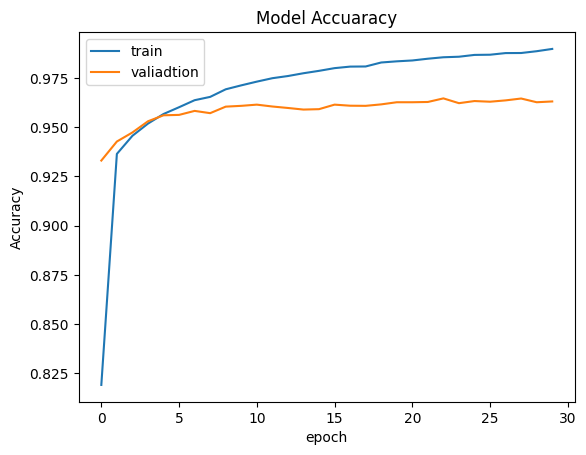

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuaracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend(["train","valiadtion"],loc='upper left')
plt.show()

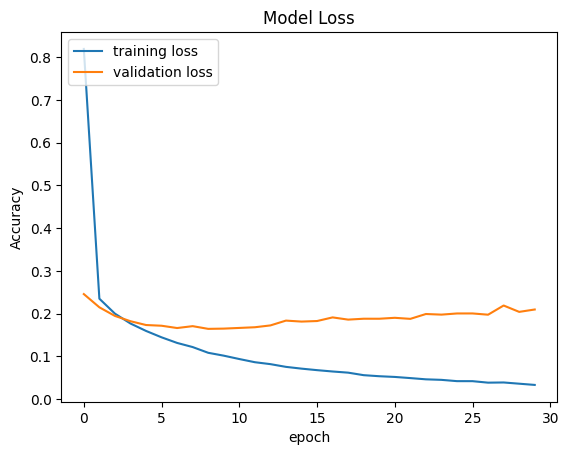

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend(["training loss","validation loss"],loc='upper left')
plt.show()

## Decoding test sentences

Finally, let's demonstrate how to translate brand new English sentences.
We simply feed into the model the vectorized English sentence
as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [ ]:
# spa_vocab = spa_vectorization.get_vocabulary()
# spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
# max_decoded_sentence_length = 20


# def decode_sequence(input_sentence):
#     tokenized_input_sentence = eng_vectorization([input_sentence])
#     decoded_sentence = "[start]"
#     for i in range(max_decoded_sentence_length):
#         tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
#         predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

#         sampled_token_index = np.argmax(predictions[0, i, :])
#         sampled_token = spa_index_lookup[sampled_token_index]
#         decoded_sentence += " " + sampled_token

#         if sampled_token == "[end]":
#             break
#     return decoded_sentence


# test_eng_texts = [pair[0] for pair in test_pairs]
# for _ in range(30):
#     input_sentence = random.choice(test_eng_texts)
#     translated = decode_sequence(input_sentence)
#     # print(input_sentence, "----- ", translated)

#     src = ""
#     for ch in input_sentence:
#       if ch != " ":
#         src += ch

#     trg = ""
#     for ch in translated:
#       if ch != " ":
#         trg += ch


#     print("Src: ", src, "-----------> trg: ", trg)


After 30 epochs, we get results such as:

> She handed him the money.
> [start] ella le pasó el dinero [end]

> Tom has never heard Mary sing.
> [start] tom nunca ha oído cantar a mary [end]

> Perhaps she will come tomorrow.
> [start] tal vez ella vendrá mañana [end]

> I love to write.
> [start] me encanta escribir [end]

> His French is improving little by little.
> [start] su francés va a [UNK] sólo un poco [end]

> My hotel told me to call you.
> [start] mi hotel me dijo que te [UNK] [end]

In [ ]:
# def sentence_word(sentence):
#   trg=''
#   for ch in sentence:
#       if ch != " ":
#         trg += ch
#   return trg

In [ ]:
# words=["দেখেছিলাম", "দেখবো",  "ভেবেছিলাম", "জাকির"]
# for word in words:
#   translated = decode_sequence(word_sentence(word))
#   print(word," ",sentence_word(translated))

In [ ]:
# input_text="টিভি ফুটেজে দেখা ফিলিং স্টেশনের কর্মচারীরা প্রিয় মানুষের মধ্যে কথা কাটাকাটি হয় একপর্যায়ে রাপে হেঁটে অফিসে ভেতর থেকে ছুটি নিয়ে এসে মানুষের পক্ষে উপর্যুপরি আঘাত করে মানুষ দূরে অফিসের পেছনে যে মাটিতে লুটিয়ে পড়েন হাসপাতালে নেয়ার পর তাকে মৃত ঘোষণা করেন চিকিৎসক হত্যাকাণ্ডের পর ঘাতকরা বিয়ে বাড়িতে পৌঁছে ছবিটি চালের ড্রামে লুকিয়ে দেখে বাসে করে বাড়ি থেকে একটি হোটেলে আত্মগোপন করেন তারা সংখ্যায় সেখান থেকে চট্টগ্রামে চলে যায় এরপর কুড়িগ্রামে বন্ধুর কাছে যাওয়ার জন্য বাসে উঠলেই কুমিল্লা পদুয়ার বাজার বিশ্বরোড থেকে তাকে গ্রেফতার করে পরে স্বীকারোক্তি অনুযায়ী তার বাড়ি থেকে উত্তোলন করা হয় হত্যায় ব্যবহৃত রক্তমাখা ছুরি তাদের অফিসে চাকুরী নিয়ে এসে তাকে ছুরিকাঘাতে ছুরিকাঘাত করে হত্যা করে সদর দক্ষিণে বিজয়পুর খোসা গাঁও গ্রামে আজকে ফিলিং স্টেশনে বকশিশের মাত্র টাকা ভাগাভাগি নিয়ে গত বুধবার ঘটে হত্যাকান্ড সময় সংবাদ কুমিল্লা"

In [ ]:
# input_text=input_text.replace("য়","য়")
# input_texts=input_text.split(" ")
# output_texts=[]
# thik_ase=[]
# for word in input_texts:
#   translated = decode_sequence(word_sentence(word))
#   trg = sentence_word(translated)
#   trg = trg[7:]
#   trg = trg[:-5]
#   # print(trg)
#   print(word,"------->", trg)
#   #x=input()
#   #thik_ase.append(int(x))


In [ ]:
# sum=0
# for x in thik_ase:
#   sum=sum+x
# accuracy=sum/len(thik_ase)*100
# print(accuracy,"%")

##Save Model

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
#tf.saved_model.save(transformer, export_dir='/content/drive/MyDrive/THESIS/Saved_Model_Lemmatization/banel_90_10_with_pos')

# Inference Model

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import numpy as np

new_model=tf.saved_model.load('/content/drive/MyDrive/THESIS/Saved_Model_Lemmatization/banel_90_10_with_pos')
#vocab=['', '[UNK]', '[start]', '[end]', 'া', '্', 'র', 'ন', 'ি', 'ক', 'ত', 'ব', 'প', 'ম', 'ল', 'অ', 'দ', 'স', 'ু', 'ে', 'আ', 'গ', 'শ', 'ো', 'য', 'চ', 'জ', 'য়', 'ট', 'ী', 'হ', 'ষ', 'ধ', 'ভ', 'খ', 'উ', 'ড়', 'ণ', 'ছ', 'ও', 'ড', 'ই', 'থ', 'ঁ', 'ঘ', 'ং', 'ফ', 'ৃ', 'ূ', 'ঠ', 'এ', 'ঙ', '়', 'ঞ', 'ৌ', 'ঝ', 'ৎ', 'ৈ', 'ঢ', 'ঔ', 'ঐ', 'ঃ', 'ঈ', 'ঋ', 'ঢ়', 'ঊ', '৪', '৬', '৩', '২', '১', 'ৄ']
vocab = ['', '[UNK]', '[end]', '[start]', 'ঁ', 'ং', 'ঃ', 'অ', 'অন্যান্য', 'অব্যয়', 'অব্যয়েরবিশেষণ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'ক্রিয়া', 'ক্রিয়াবিশেষণ', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'বিশেষণ', 'বিশেষণেরবিশেষণ', 'বিশেষ্য', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'সর্বনাম', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ৄ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', 'ড়', 'ঢ়', 'য়', '১', '২', '৩', '৪', '৬']

vocab_size = 150
sequence_length = 20
batch_size = 64

eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
    vocabulary=vocab
)

spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    vocabulary=vocab
)

spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence2(input_sentence):
    #print(":",input_sentence, ":")
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = new_model([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

def sentence_word(sentence):
  trg=''
  for ch in sentence:
      if ch != " ":
        trg += ch
  return trg

def word_sentence(word):
  sentence = ""
  for ch in word:
    sentence += (ch + " ")
  return sentence
def predict(word):
  return sentence_word(decode_sequence2(word_sentence(word)))


# Loading Test Dataset

In [52]:
url = "https://raw.githubusercontent.com/Jak57/datasets/main/banel/banel_pos_90_10/banel_pos_test_2235_90_10.csv"
df = pd.read_csv(url)
print("Shape:", df.shape, "\n")
df.head(2)

Shape: (2235, 4) 



,Unnamed: 0,Inflected_Word,Lemma,POS
0,0,গ্যাসে,গ্যাস,বিশেষ্য
1,1,আয়করযোগ্য,আয়কর,বিশেষ্য


In [56]:
data = []
inf_word = []
lemma = []
pred = []
cnt = 0
for index, row in df.iterrows():
  word = word_sentence(row["Inflected_Word"])
  translated = decode_sequence2(word + row["POS"])
  trg = sentence_word(translated)
  #print(word, translated, trg)
  trg = trg[7:]
  trg = trg[:-5]
  # print(word, translated, trg)
  inf_word.append(row["Inflected_Word"])
  lemma.append(row["Lemma"])
  pred.append(trg)
  cnt += 1
  print("----->", cnt)
  # print(row["Inflected_Word"], trg)
  # if cnt == 50:
  #   break

-----> 1
-----> 2
-----> 3
-----> 4
-----> 5
-----> 6
-----> 7
-----> 8
-----> 9
-----> 10
-----> 11
-----> 12
-----> 13
-----> 14
-----> 15
-----> 16
-----> 17
-----> 18
-----> 19
-----> 20
-----> 21
-----> 22
-----> 23
-----> 24
-----> 25
-----> 26
-----> 27
-----> 28
-----> 29
-----> 30
-----> 31
-----> 32
-----> 33
-----> 34
-----> 35
-----> 36
-----> 37
-----> 38
-----> 39
-----> 40
-----> 41
-----> 42
-----> 43
-----> 44
-----> 45
-----> 46
-----> 47
-----> 48
-----> 49
-----> 50
-----> 51
-----> 52
-----> 53
-----> 54
-----> 55
-----> 56
-----> 57
-----> 58
-----> 59
-----> 60
-----> 61
-----> 62
-----> 63
-----> 64
-----> 65
-----> 66
-----> 67
-----> 68
-----> 69
-----> 70
-----> 71
-----> 72
-----> 73
-----> 74
-----> 75
-----> 76
-----> 77
-----> 78
-----> 79
-----> 80
-----> 81
-----> 82
-----> 83
-----> 84
-----> 85
-----> 86
-----> 87
-----> 88
-----> 89
-----> 90
-----> 91
-----> 92
-----> 93
-----> 94
-----> 95
-----> 96
-----> 97
-----> 98
-----> 99
-----> 100
-----> 1

In [57]:
print(len(inf_word), len(lemma), len(pred))

2235 2235 2235


In [58]:
data = {
    "Inflected_Word": inf_word,
    "Lemma_Correct": lemma,
    "Lemma_Predict": pred
}
df = pd.DataFrame(data, columns=data.keys())
df.head(50)

,Inflected_Word,Lemma_Correct,Lemma_Predict
0,গ্যাসে,গ্যাস,গ্যাস
1,আয়করযোগ্য,আয়কর,আয়করযোগ্য
2,পিছাতে,পিছন,পিছন
3,আড্ডাটা,আড্ডা,আড্ডা
4,সমুদ্রটা,সমুদ্র,সমুদ্র
5,অথবা,অথবা,অথবা
6,অভিজ্ঞান,অভিজ্ঞান,অভিজ্ঞান
7,কোম্পানিতে,কোম্পানি,কোম্পান
8,অনাথকে,অনাথ,অনাথ
9,প্রফুল্লই,প্রফুল্ল,প্রফুল্ল


In [59]:
url = "/content/drive/MyDrive/THESIS/Testing_Lemmatizer/banel_pos_prediction_90_10.csv"
df.to_csv(url)